In [1]:
#####################
# IMPORT LIBS
#####################

from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import io, transform
from skimage.transform import AffineTransform, warp
from sklearn.metrics import roc_auc_score, mean_absolute_error
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.compat.v1.keras import backend as K

import pandas as pd
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
import albumentations as A
import cv2
import wandb
from wandb.keras import WandbCallback
import datetime


#####################
# SET CONSTANTS
#####################

INPUT_PATH = Path('../input')
OUTPUT_PATH = Path('../output')
TRAIN_PATH = INPUT_PATH / 'idao_dataset' / 'train'
PRIVATE_PATH = INPUT_PATH / 'idao_dataset' / 'private_test'
PUBLIC_PATH = INPUT_PATH / 'idao_dataset' / 'public_test'

RANDOM_SEED = 4444
USE_WANDB = True

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(RANDOM_SEED)


if USE_WANDB:
    CURRENT_TIME = str(datetime.datetime.now()).replace(' ', '_').split('.')[0]
    RUN_NAME = 'own'

    wandb.login()
    run = wandb.init(project="idao-regression", name = f'{RUN_NAME}_{CURRENT_TIME}')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


wandb: Currently logged in as: artkulak (use `wandb login --relogin` to force relogin)


In [2]:
class Config:
    BATCH_SIZE = 64
    TRAINING_EPOCHS = 250
    VALIDATION_STEPS_PER_EPOCH = 10
    VALIDATION_EPOCHS = 10
    STEPS_PER_EPOCH = 30
    EARLY_STOP_PATIENCE = 30
    
    
    # Declare an augmentation pipeline
    train_transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.Cutout(num_holes=4, max_h_size=8, max_w_size=8, p=0.3),
        A.OneOf([A.RandomContrast(),
             A.RandomGamma(),
             A.RandomBrightness()],p=0.2),
        A.OneOf([A.Blur(p = 0.3),
             A.GaussNoise(p=0.3)
                ],p=0.5),
        A.CLAHE(clip_limit=4, tile_grid_size=(8,8), always_apply=False, p=0.3),
    ],)
    
    validation_transform = A.Compose([
    ],)

In [3]:
def getFeatures(img_path):
    if len(img_path.split('_')) == 18:
        particle_class = 1 # ER
        particle_energy = int(img_path.split('_')[7])
    else:
        particle_class = 0 # HE
        particle_energy = int(img_path.split('_')[8])
    particle_angle = float(img_path.split('/')[-1].split('__')[0])
    return [img_path, particle_class, particle_energy, particle_angle]

images = glob.glob(str(TRAIN_PATH / '**/*.png'), recursive=True)
images = pd.DataFrame(map(getFeatures, images))
images.columns = ['path', 'class', 'energy', 'angle']

In [4]:
#################
# EXTRACT TEST
#################

# HE - 0, ER - 1

he_test_idx = list(images[(images['class'] == 1) & (images['energy'].apply(lambda x: x in [1, 6, 20]))].index)
er_test_idx = list(images[(images['class'] == 0) & (images['energy'].apply(lambda x: x in [3, 10, 30]))].index)

In [6]:
test_idx = he_test_idx + er_test_idx
test_images = images.iloc[test_idx]
images = images.drop(index = test_idx)


train_images, valid_images = train_test_split(images, shuffle = True, random_state = RANDOM_SEED)
train_images = train_images.reset_index(drop = True)
valid_images = valid_images.reset_index(drop = True)

In [7]:
def calc_metric(y_binary_true, y_binary_pred, y_reg_true, y_reg_pred):
    '''
    Competition metric
    '''
    
    roc = roc_auc_score(y_binary_true, y_binary_pred)
    mae = mean_absolute_error(y_reg_true, y_reg_pred)
    return 1000 * (roc - mae), roc, mae

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, transform=None, batch_size=32,  shuffle=True, is_classification = True, augment = False):
        self.images = images
        self.indices = np.arange(len(images))
        self.transform = transform
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.is_classification = is_classification
        
        self.on_epoch_end()

    def __len__(self):
        int_batch_size = len(self.images) // self.batch_size
        
#         if len(self.images) % self.batch_size != 0:
#             return int_batch_size + 1
        return int_batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
    
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle:
            np.random.shuffle(self.index)
            
    def get_label(self, y_energy):
        if (y_energy>=1)&(y_energy <= 3):
            y_energy = [1,0,0]
        elif (y_energy>=6)&(y_energy <= 10):
            y_energy = [0,1,0]
        elif (y_energy>=20)&(y_energy <= 30):
            y_energy = [0,0,1]
        
        return y_energy

    def __get_data(self, batch):
        X = np.zeros((len(batch), 128, 128, 3))
        y_class = np.zeros((len(batch),))
        y_energy = np.zeros((len(batch),))
        y_angle = np.zeros((len(batch),))
        for i, idx in enumerate(batch):
            image=cv2.imread(self.images.iloc[idx, 0])
            center = image.shape[0] // 2
            image = image[center-128//2:center+128//2,center-128//2:center+128//2, :]
            X[i,] = image
            
            if self.augment:
                X[i, ] = Config.train_transform(image=X[i,].astype(np.uint8))['image']
            particle_class = self.images.iloc[idx, 1]
            particle_energy = self.images.iloc[idx, 2]
            particle_angle = self.images.iloc[idx, 3]
            
            y_class[i] = particle_class
            y_energy[i] = particle_energy # self.get_label(particle_energy)
            y_angle[i] = particle_angle
        if self.is_classification:
            return X / 255.0, y_class
        
        return X / 255.0, y_energy

In [9]:
train_datagen = DataGenerator(train_images, batch_size = Config.BATCH_SIZE, is_classification = False, augment = False)
valid_datagen = DataGenerator(valid_images, batch_size = Config.BATCH_SIZE, is_classification = False)
test_datagen = DataGenerator(test_images, batch_size = 1, is_classification = False, shuffle = False)

In [10]:
# Example data extract

X, y_energy = train_datagen.__getitem__(0)

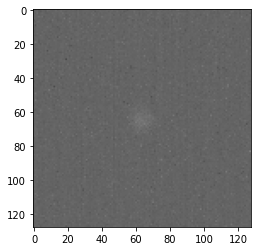

In [11]:
idx = 17
plt.imshow((X[idx] * 255).astype(np.uint8))

## Class model

In [12]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet201
from tensorflow.keras.applications import ResNet152V2

from tensorflow.keras.applications import EfficientNetB0
import numpy as np

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
MODEL_NAME = 'regression_MobileNetV2'

In [13]:
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras
import tensorflow
from tensorflow.keras import regularizers

earlystop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=Config.EARLY_STOP_PATIENCE)
ckpt = tensorflow.keras.callbacks.ModelCheckpoint(OUTPUT_PATH / 'models' / MODEL_NAME, save_best_only=True, monitor='val_mean_absolute_error', mode='min')
    
def create_regression_model():
    
    # Model receives black and white 64 x 64 images as input
    inp = L.Input(shape=(128,128,3))

        # Sequence of two convolutional and pooling layers as feature extractors
#     x = L.Conv2D(16, kernel_size=2, activation='relu')(inp)
#     x = L.BatchNormalization()(x)
    x = L.Conv2D(16, kernel_size=2, activation='relu')(inp)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = L.Conv2D(32, kernel_size=2, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(32, kernel_size=2, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = L.Conv2D(64, kernel_size=4, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(64, kernel_size=4, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    
    # and a logistic layer -- let's say we have 200 classes
#     predictions_energy = L.Dense(3, activation= 'softmax', name='energy')(x)
    x = L.GlobalAveragePooling2D()(x)
    x = L.Dense(64, activation='relu')(x)
    predictions_energy = L.Dense(1, name='energy')(x)
#     predictions_class = L.Dense(1, activation='sigmoid', name='class')(x)
#     predictions_angle = L.Dense(1, name='angle')(x)

    # this is the model we will train
    model = Model(inputs=[inp], outputs=[predictions_energy])


    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss={#'class': 'binary_crossentropy', 
                        'energy':'mean_absolute_error', 
                        #'angle': 'mean_absolute_error'
                  },
                  metrics = {#'class': 'AUC', 
                             'energy': 'mean_absolute_error', 
                             #'angle': 'mean_absolute_error'
                  })
    return model

In [15]:
#model = create_regression_model(base_model)
model = create_regression_model()

In [16]:
class ModelCustomEval(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        private_loss, private_mae = self.model.evaluate(test_datagen, batch_size=8, steps=test_images.shape[0])
        #_, private_loss, _, _, private_mae, _, _ = self.model.evaluate(test_datagen, batch_size=8, steps=test_images.shape[0])
        wandb.log({'private_loss': private_loss, 'private_mae': private_mae})
        print(f'Private MAE is {private_mae}')

In [17]:
if USE_WANDB:
    model.fit(
        train_datagen, 
        steps_per_epoch = Config.STEPS_PER_EPOCH, 
        validation_data = valid_datagen, 
        validation_steps = Config.VALIDATION_STEPS_PER_EPOCH, 
        epochs = Config.TRAINING_EPOCHS,
        verbose = 1,
        callbacks = [earlystop, ckpt, WandbCallback(), ModelCustomEval()] # add checkpoint later
        )
else:
    model.fit(
        train_datagen, 
        steps_per_epoch = Config.STEPS_PER_EPOCH, 
        validation_data = valid_datagen, 
        validation_steps = Config.VALIDATION_STEPS_PER_EPOCH, 
        epochs = Config.TRAINING_EPOCHS,
        verbose = 1,
        callbacks = [earlystop]
        )

Epoch 1/250
30/30 [==============================] - 11s 289ms/step - loss: 10.3674 - mean_absolute_error: 10.3674 - val_loss: 12.2021 - val_mean_absolute_error: 12.2021
INFO:tensorflow:Assets written to: ../output/models/regression_MobileNetV2/assets
12/12 [==============================] - 0s 4ms/step - loss: 11.2911 - mean_absolute_error: 11.2911
Private MAE is 11.29112720489502
Epoch 2/250
30/30 [==============================] - 8s 280ms/step - loss: 9.3371 - mean_absolute_error: 9.3371 - val_loss: 11.9180 - val_mean_absolute_error: 11.9180
INFO:tensorflow:Assets written to: ../output/models/regression_MobileNetV2/assets
12/12 [==============================] - 0s 4ms/step - loss: 11.1258 - mean_absolute_error: 11.1258
Private MAE is 11.125831604003906
Epoch 3/250
30/30 [==============================] - 8s 276ms/step - loss: 8.1511 - mean_absolute_error: 8.1511 - val_loss: 10.8470 - val_mean_absolute_error: 10.8470
INFO:tensorflow:Assets written to: ../output/models/regression_Mo

INFO:tensorflow:Assets written to: ../output/models/regression_MobileNetV2/assets
12/12 [==============================] - 0s 4ms/step - loss: 3.0981 - mean_absolute_error: 3.0981
Private MAE is 3.098057746887207
Epoch 25/250
30/30 [==============================] - 8s 278ms/step - loss: 1.7276 - mean_absolute_error: 1.7276 - val_loss: 1.6176 - val_mean_absolute_error: 1.6176
INFO:tensorflow:Assets written to: ../output/models/regression_MobileNetV2/assets
12/12 [==============================] - 0s 4ms/step - loss: 1.8661 - mean_absolute_error: 1.8661
Private MAE is 1.8661456108093262
Epoch 26/250
12/12 [==============================] - 0s 4ms/step - loss: 3.4380 - mean_absolute_error: 3.4380
Private MAE is 3.437972068786621
Epoch 27/250
12/12 [==============================] - 0s 4ms/step - loss: 2.3330 - mean_absolute_error: 2.3330
Private MAE is 2.3329546451568604
Epoch 28/250
30/30 [==============================] - 8s 280ms/step - loss: 1.5508 - mean_absolute_error: 1.5508 - val

12/12 [==============================] - 0s 4ms/step - loss: 1.7655 - mean_absolute_error: 1.7655
Private MAE is 1.7655471563339233
Epoch 51/250
12/12 [==============================] - 0s 4ms/step - loss: 1.9766 - mean_absolute_error: 1.9766
Private MAE is 1.9766311645507812
Epoch 52/250
12/12 [==============================] - 0s 4ms/step - loss: 1.8131 - mean_absolute_error: 1.8131
Private MAE is 1.813089370727539
Epoch 53/250
12/12 [==============================] - 0s 4ms/step - loss: 2.1428 - mean_absolute_error: 2.1428
Private MAE is 2.142806053161621
Epoch 54/250
30/30 [==============================] - 8s 284ms/step - loss: 1.2545 - mean_absolute_error: 1.2545 - val_loss: 1.0839 - val_mean_absolute_error: 1.0839
INFO:tensorflow:Assets written to: ../output/models/regression_MobileNetV2/assets
12/12 [==============================] - 0s 4ms/step - loss: 1.9290 - mean_absolute_error: 1.9290
Private MAE is 1.928960919380188
Epoch 55/250
12/12 [==============================] - 0s

12/12 [==============================] - 0s 4ms/step - loss: 1.8572 - mean_absolute_error: 1.8572
Private MAE is 1.857221007347107
Epoch 78/250
12/12 [==============================] - 0s 4ms/step - loss: 2.1319 - mean_absolute_error: 2.1319
Private MAE is 2.1319401264190674
Epoch 79/250
12/12 [==============================] - 0s 4ms/step - loss: 1.9673 - mean_absolute_error: 1.9673
Private MAE is 1.9673405885696411
Epoch 80/250
12/12 [==============================] - 0s 4ms/step - loss: 2.2897 - mean_absolute_error: 2.2897
Private MAE is 2.2897040843963623
Epoch 81/250
12/12 [==============================] - 0s 4ms/step - loss: 2.2510 - mean_absolute_error: 2.2510
Private MAE is 2.2510366439819336
Epoch 82/250
12/12 [==============================] - 0s 4ms/step - loss: 2.1729 - mean_absolute_error: 2.1729
Private MAE is 2.172945022583008
Epoch 83/250
12/12 [==============================] - 0s 4ms/step - loss: 1.7558 - mean_absolute_error: 1.7558
Private MAE is 1.755797028541565
E

In [18]:
model = tensorflow.keras.models.load_model(OUTPUT_PATH / 'models' / MODEL_NAME)

In [19]:
_, public_mae = model.evaluate(valid_datagen, batch_size=64, steps=valid_images.shape[0] // 64)
#_, _, _, _, public_mae, _, _ = model.evaluate(valid_datagen, batch_size=64, steps=valid_images.shape[0] // 64)
wandb.run.summary["public_mae"] = public_mae

51/51 [==============================] - 11s 204ms/step - loss: 0.9561 - mean_absolute_error: 0.9561


In [20]:
_, private_mae = model.evaluate(test_datagen, batch_size=8, steps=test_images.shape[0])
#_, _, _, _, private_mae, _, _ = model.evaluate(test_datagen, batch_size=8, steps=test_images.shape[0])
wandb.run.summary["private_mae"] = private_mae

12/12 [==============================] - 0s 4ms/step - loss: 1.9189 - mean_absolute_error: 1.9189


In [1]:
if USE_WANDB:
    run.finish()